In [ ]:
import warnings;
warnings.simplefilter('ignore')

# **Importation des bibliothèques**

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, InputLayer, Flatten
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import random

# **Main Code**

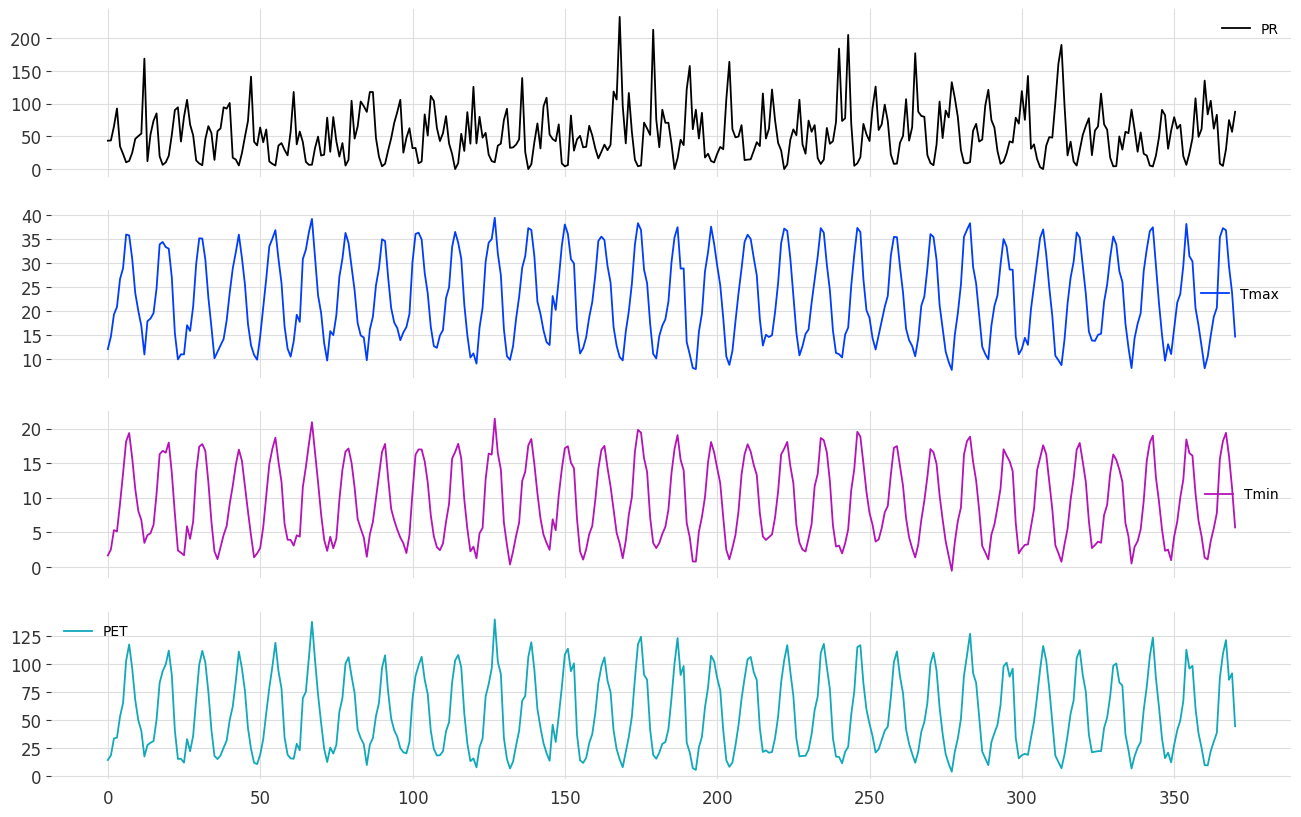

<Figure size 640x480 with 0 Axes>

In [ ]:
df = pd.read_excel('/content/Taoura.xlsx', sheet_name='Feuil1')
df.head()

cols=["Year","Month"]
df['Date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

df.drop(['Year', 'Month'], axis = 1, inplace = True)

cols = df.columns.tolist()
#cols

cols = cols[-1:] + cols[:-1]
#cols

df = df[cols]
#df.head()

columns_na = df.isna().sum().tolist()
columns_na

#df.shape

#df.describe(include='all')

df.iloc[0:-1].plot(subplots = True, fontsize = 12, figsize = (16,10))
plt.show()
plt.savefig('/content/description.png')

<ipython-input-3-d5621ef5406b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


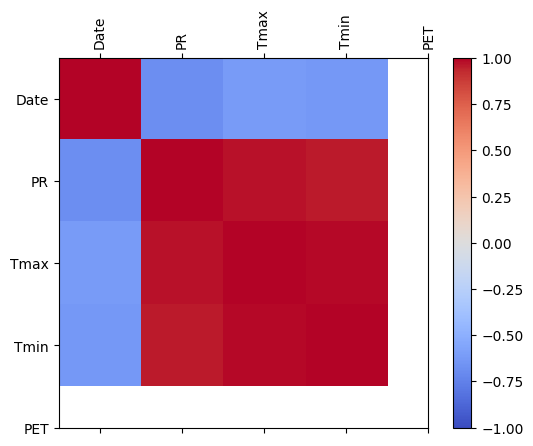

In [ ]:
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

In [ ]:
corr

,PR,Tmax,Tmin,PET
PR,1.000000,-0.681909,-0.615734,-0.626629
Tmax,-0.681909,1.000000,0.970364,0.957433
Tmin,-0.615734,0.970364,1.000000,0.986808
PET,-0.626629,0.957433,0.986808,1.000000


In [ ]:
from keras import backend as K
def val_mse(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred), axis=-1)
    return mse

In [ ]:
features = ['PR', 'Tmax', 'Tmin', 'PET']
features_len = len(features)
#dates = df['Date']

#scale = 1
train_prop = .8
sequence_len = 12 # 12 mois
learning_rate = 0.001
batch_size = 64
epochs= 100

#df = df[:int(scale * len(df))]
df = df[:len(df)]
train_len = int(train_prop * len(df))

dataset_train = df.loc[ :train_len-1, features]
dataset_test = df.loc[train_len:, features]
#print("=====Train Dataset Example=========")
#display(dataset_train.head(5))

#df.drop('Date', axis = 1, inplace = True)

#df.columns

mean = dataset_train.mean()
print('Moyenne:\n',mean)
std = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test = (dataset_test - mean) / std
#display(dataset_train.describe().style.format('{0:.2f}'))

dataset_train = dataset_train.to_numpy()
dataset_test = dataset_test.to_numpy()

print('Dataset: ', df.shape)
print('Train dataset: ', dataset_train.shape)
print('Test dataset: ', dataset_test.shape)

from keras.preprocessing.sequence import TimeseriesGenerator

train_generator = TimeseriesGenerator(dataset_train, dataset_train, length = sequence_len, batch_size = batch_size)
test_generator = TimeseriesGenerator(dataset_test, dataset_test, length = sequence_len, batch_size = batch_size)

x, y = train_generator[0]
x_val, y_val = test_generator[0]
print(f'nombre de batches disponibles: ', len(train_generator))
print('train batch x shape: ', x.shape)
print('train batch y shape: ', y.shape)

print('What a train batch looks like (x):')
print(x[0])
print('What a train batch looks like (y):')
print(y[0])
print('=======================================================================')
print('validation batch x shape: ', x_val.shape)
print('validation batch y shape: ', y_val.shape)
print('What a validation batch looks like (x):')
print(x_val[0])
print('What a validation batch looks like (y):')
print(y_val[0])

Moyenne:
 PR      53.294211
Tmax    23.006721
Tmin     9.492785
PET     56.066860
dtype: float64
Dataset:  (372, 5)
Train dataset:  (297, 4)
Test dataset:  (75, 4)
nombre de batches disponibles:  5
train batch x shape:  (64, 12, 4)
train batch y shape:  (64, 4)
What a train batch looks like (x):
[[-0.24899588 -1.21080959 -1.36544113 -1.19572101]
 [-0.24244899 -0.92325748 -1.21434583 -1.07898668]
 [ 0.29354887 -0.41106494 -0.72688148 -0.64544113]
 [ 0.98782362 -0.23479224 -0.75956765 -0.6205807 ]
 [-0.46742172  0.40992462 -0.055748   -0.08143997]
 [-0.75701357  0.66156272  0.70752828  0.26682498]
 [-1.08022236  1.44120273  1.50891969  1.34551109]
 [-1.02882021  1.41995782  1.71896482  1.76668397]
 [-0.71608544  0.88034923  1.08706971  1.15237219]
 [-0.17921768  0.08584979  0.31155016  0.34248571]
 [-0.07366539 -0.32409286 -0.24422699 -0.17818453]
 [ 0.02356752 -0.67932688 -0.4775231  -0.4524147 ]]
What a train batch looks like (y):
[ 2.90191959 -1.33611852 -1.0492502  -1.10521891]
valid

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape = (sequence_len, features_len)))
model.add(LSTM(256, activation = "sigmoid",return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation = "tanh",return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(256, activation = "tanh",return_sequences = True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(features_len))

save_dir = f'/content/model5.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)



model.compile(optimizer= Adam(learning_rate=learning_rate),
              loss='mse',
              metrics=['accuracy', 'mae', 'mse', val_mse])

history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    batch_size= batch_size,
                    validation_data=test_generator,
                    callbacks=[bestmodel_callback],
                    shuffle=False)

Epoch 1/100
5/5 [==============================] - 8s 484ms/step - loss: 1.0582 - accuracy: 0.2877 - mae: 0.8743 - mse: 1.0582 - val_mse: 0.9833 - val_loss: 0.9833 - val_accuracy: 0.5238 - val_mae: 0.8529 - val_val_mse: 0.9833
Epoch 2/100
5/5 [==============================] - 1s 202ms/step - loss: 1.0082 - accuracy: 0.3719 - mae: 0.8712 - mse: 1.0082 - val_mse: 0.9584 - val_loss: 0.9584 - val_accuracy: 0.1746 - val_mae: 0.8383 - val_val_mse: 0.9584
Epoch 3/100
5/5 [==============================] - 1s 203ms/step - loss: 0.9819 - accuracy: 0.2105 - mae: 0.8510 - mse: 0.9819 - val_mse: 0.9118 - val_loss: 0.9118 - val_accuracy: 0.6984 - val_mae: 0.8167 - val_val_mse: 0.9118
Epoch 4/100
5/5 [==============================] - 1s 205ms/step - loss: 0.8965 - accuracy: 0.5263 - mae: 0.8182 - mse: 0.8965 - val_mse: 0.7281 - val_loss: 0.7281 - val_accuracy: 0.6508 - val_mae: 0.7288 - val_val_mse: 0.7281
Epoch 5/100
5/5 [==============================] - 1s 230ms/step - loss: 0.5910 - accuracy: 

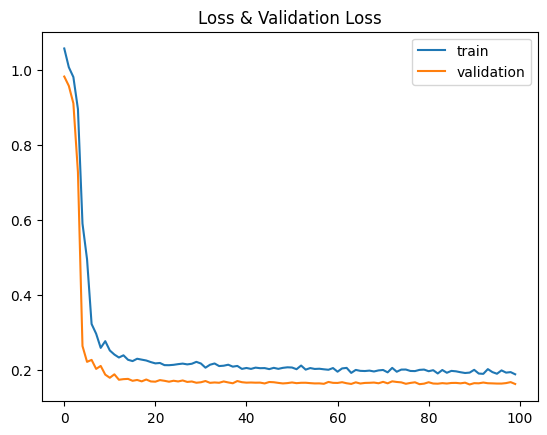

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss & Validation Loss')
plt.legend()
plt.show()
plt.savefig('/content/Loss & Validation Loss 2.png')

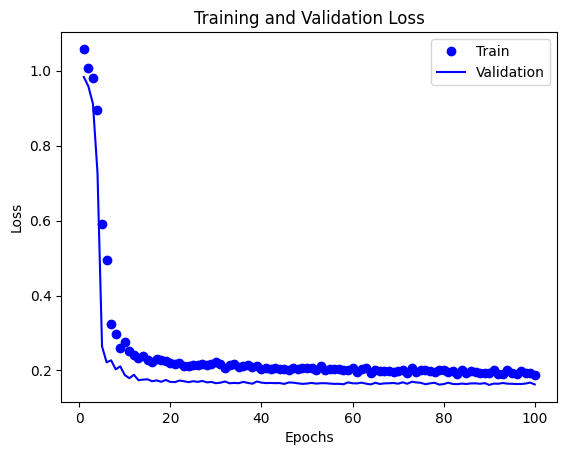

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss)+1)
plt.plot(epochs, training_loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.savefig('/content/Training_and_Validation_Loss.png')

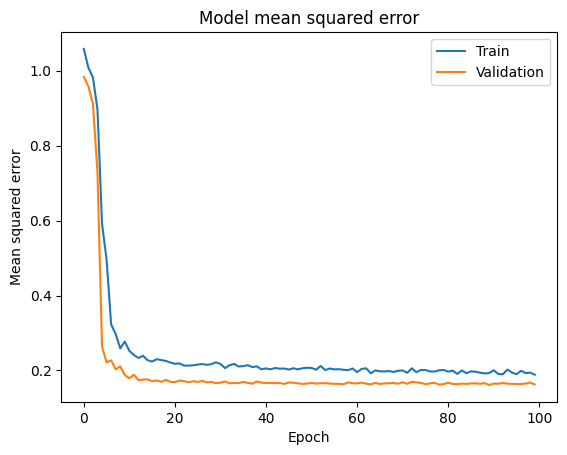

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot training & validation MSE values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model mean squared error')
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.savefig('/content/MSE_Values.png')

2/2 [==============================] - 1s 38ms/step


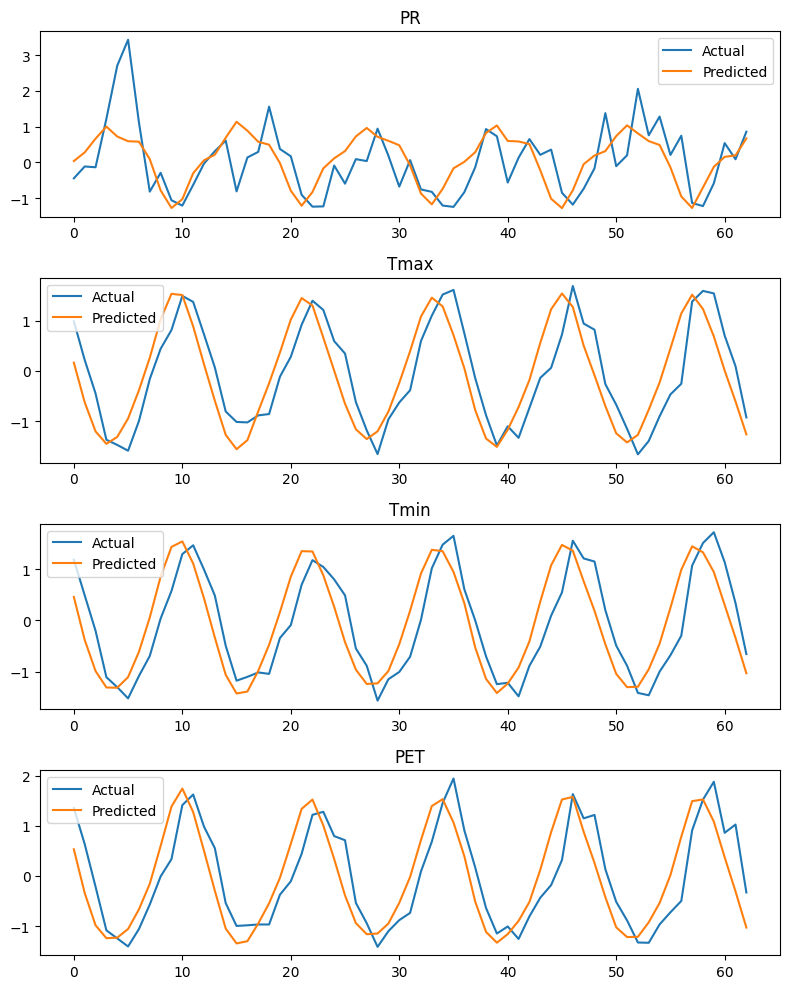

<Figure size 640x480 with 0 Axes>

In [ ]:
# Generate predictions for a sample of test data
test_data = iter(test_generator)
test_data = next(test_data)
predictions = model.predict(test_data[0])
# Plot actual vs. predicted values
fig, axs = plt.subplots(nrows=features_len, figsize=(8, 10))
for i in range(features_len):
    axs[i].plot(test_data[0][:, -1, i], label='Actual')
    axs[i].plot(predictions[:, i], label='Predicted')
    axs[i].set_title(features[i])
    axs[i].legend()
fig.tight_layout()
plt.show()
plt.savefig('/content/Actual_VS_Predicted_Values.png')